# Analyse de la représentativité du Baromètre Basta

Ce notebook analyse la représentativité du baromètre en comparant les distributions observées (questionnaire) avec les distributions attendues (population marseillaise).

# SECTION 1 : CHARGEMENT ET PRÉPARATION DES DONNÉES

## 1.1. Import des bibliothèques

In [1]:
import pandas as pd
import re
import glob
from scipy.stats import chisquare, chi2_contingency
import numpy as np
import matplotlib.pyplot as plt

In [52]:
# Mapping secteur → arrondissements (INSEE Marseille)
secteur_arr_mapping = {
    "1ER SECTEUR": [1, 7],
    "2EME SECTEUR": [2, 3],
    "3EME SECTEUR": [4, 5],
    "4EME SECTEUR": [6, 8],
    "5EME SECTEUR": [9, 10],
    "6EME SECTEUR": [11, 12],
    "7EME SECTEUR": [13, 14],
    "8EME SECTEUR": [15, 16]
}


In [53]:
def get_secteur_from_arrondissement(arr_num):
    """
    Retourne le secteur (clé) correspondant à un numéro d'arrondissement (int)
    """
    for secteur, arrs in secteur_arr_mapping.items():
        if arr_num in arrs:
            return secteur
    return None

In [ ]:
# Chargement et structuration des données d'âge avec correction des secteurs/arrondissements

secteur_mapping = {}

dfs = []
for file in sorted(glob.glob('../data/raw/age_*.csv')):
    try:
        df = pd.read_csv(file, sep=',')
        if len(df.columns) == 1:
            df = pd.read_csv(file, sep=';')
    except:
        df = pd.read_csv(file, sep=';')

    id_var = None
    for col in df.columns:
        if 'âge' in col.lower() or 'age' in col.lower():
            id_var = col
            break
    
    arr_cols = [col for col in df.columns if 'arrondissement' in col.lower()]
    arrondissement = arr_cols[0].upper() if arr_cols else None

    if not arrondissement:
        file_name = file.split('/')[-1]
        match = re.search(r'age_(\d+)\.csv', file_name)
        if match:
            arr_num = int(match.group(1))
            if arr_num == 1:
                arrondissement = "1ER ARRONDISSEMENT"
            else:
                arrondissement = f"{arr_num}EME ARRONDISSEMENT"

    arr_num_match = re.search(r'(\d+)', arrondissement)
    if arr_num_match:
        arr_num = int(arr_num_match.group(1))
        secteur = get_secteur_from_arrondissement(arr_num)

    cols_to_melt = [c for c in df.columns if not re.search(r'\d', c) and c != id_var and c.lower() != 'marseille']
    subset = df[[id_var] + cols_to_melt] if cols_to_melt else df[[id_var]]
    subset = subset[subset[id_var] != 'Population']

    long_df = subset.melt(id_vars=[id_var], var_name='quartiers', value_name='population_count')
    long_df.rename(columns={id_var: "Tranche d'âge"}, inplace=True)
    long_df['arrondissements'] = arrondissement
    long_df['secteur'] = secteur
    
    dfs.append(long_df)

if len(dfs) > 0:
    df_age = pd.concat(dfs, ignore_index=True)
    print(f"\nDonnées d'âge chargées: {len(df_age)} lignes")
    display(df_age.head())
else:
    print("\nAucune donnée d'âge n'a pu être chargée")


Données d'âge chargées: 1110 lignes


,Tranche d'âge,quartiers,population_count,arrondissements,secteur
0,0-2 ans,BELSUNCE,286,1ER ARRONDISSEMENT,1ER SECTEUR
1,3-5 ans,BELSUNCE,217,1ER ARRONDISSEMENT,1ER SECTEUR
2,6-10 ans,BELSUNCE,378,1ER ARRONDISSEMENT,1ER SECTEUR
3,11-17 ans,BELSUNCE,656,1ER ARRONDISSEMENT,1ER SECTEUR
4,18-24 ans,BELSUNCE,1077,1ER ARRONDISSEMENT,1ER SECTEUR


In [ ]:
df_age.to_csv('../data/processed/age_combined.csv', index=False)

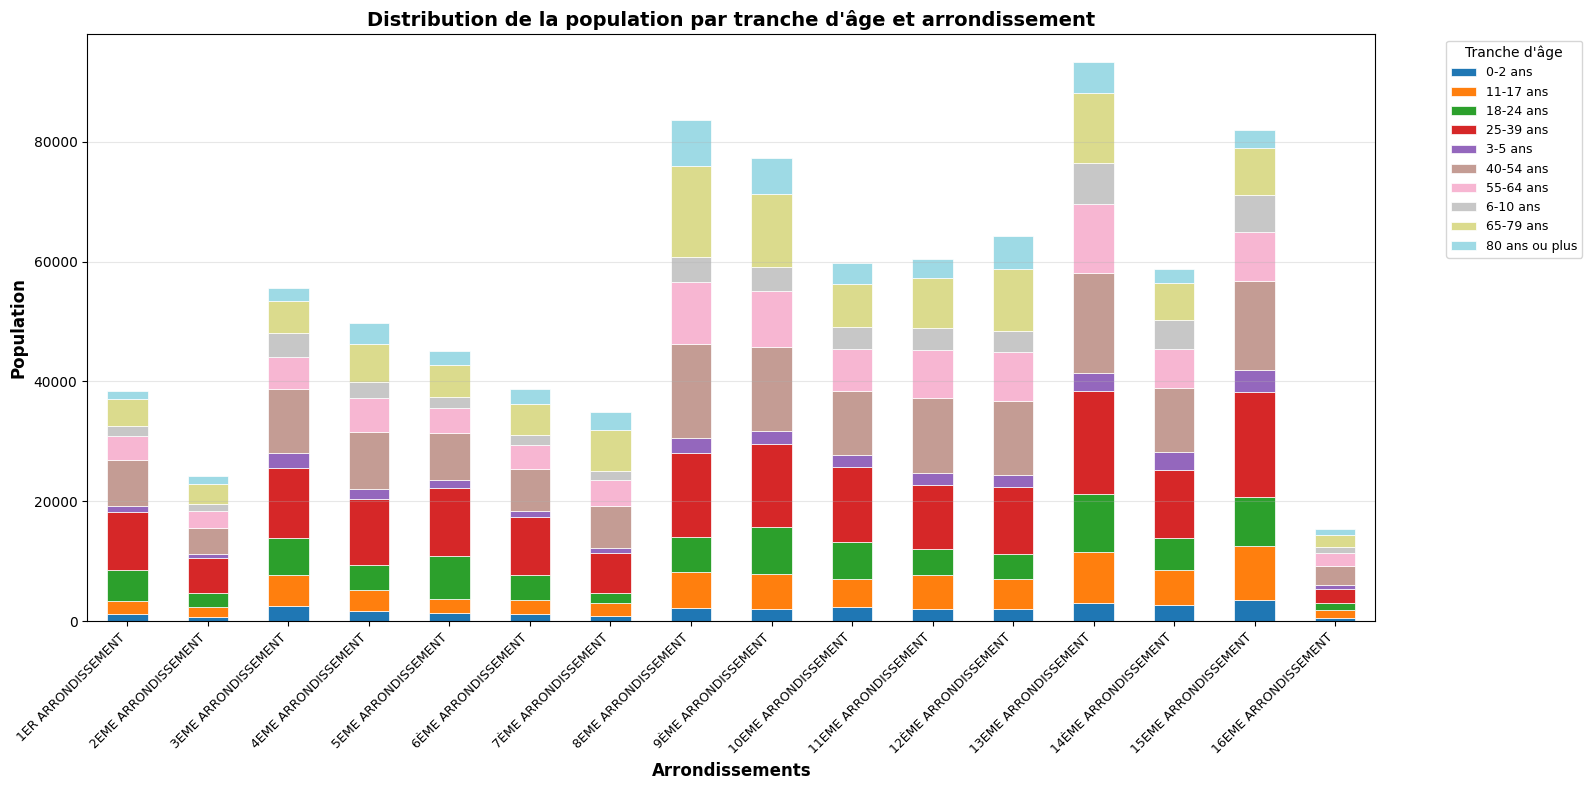


Population totale par arrondissement:
1ER ARRONDISSEMENT: 38,484 habitants
2EME ARRONDISSEMENT: 24,150 habitants
3EME ARRONDISSEMENT: 55,654 habitants
4EME ARRONDISSEMENT: 49,743 habitants
5EME ARRONDISSEMENT: 45,020 habitants
6ÈME ARRONDISSEMENT: 38,778 habitants
7ÈME ARRONDISSEMENT: 34,850 habitants
8EME ARRONDISSEMENT: 83,656 habitants
9ÈME ARRONDISSEMENT: 77,233 habitants
10EME ARRONDISSEMENT: 59,851 habitants
11EME ARRONDISSEMENT: 60,483 habitants
12ÈME ARRONDISSEMENT: 64,273 habitants
13EME ARRONDISSEMENT: 93,267 habitants
14ÈME ARRONDISSEMENT: 58,820 habitants
15EME ARRONDISSEMENT: 81,915 habitants
16EME ARRONDISSEMENT: 15,414 habitants


In [5]:
# Préparer les données pour le graphique empilé
pivot_data = df_age.pivot_table(
    values='population_count',
    index='arrondissements',
    columns='Tranche d\'âge',
    aggfunc='sum',
    fill_value=0
)

# Trier par numéro d'arrondissement (du 1er au 16ème)
def extract_arr_number(arr_name):
    """Extraire le numéro d'arrondissement pour trier"""
    match = re.search(r'(\d+)', str(arr_name))
    return int(match.group(1)) if match else 999

pivot_data['_sort_key'] = pivot_data.index.map(extract_arr_number)
pivot_data = pivot_data.sort_values('_sort_key')
pivot_data = pivot_data.drop('_sort_key', axis=1)

# Créer le graphique empilé
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
pivot_data.plot(kind='bar', stacked=True, ax=ax, colormap='tab20', edgecolor='white', linewidth=0.5)

ax.set_xlabel('Arrondissements', fontsize=12, fontweight='bold')
ax.set_ylabel('Population', fontsize=12, fontweight='bold')
ax.set_title('Distribution de la population par tranche d\'âge et arrondissement', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.legend(title='Tranche d\'âge', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Afficher aussi les totaux
totals = pivot_data.sum(axis=1)
print(f"\nPopulation totale par arrondissement:")
for arr, pop in totals.items():
    print(f"{arr}: {pop:,.0f} habitants")

In [ ]:
# Chargement et structuration des données de genre avec correction des secteurs/arrondissements

secteur_mapping = {}

dfs = []
for file in sorted(glob.glob('../data/raw/genre_*.csv')):
    try:
        df = pd.read_csv(file, sep=',')
        if len(df.columns) == 1:
            df = pd.read_csv(file, sep=';')
    except:
        df = pd.read_csv(file, sep=';')

    id_var = "Genre"

    arr_cols = [col for col in df.columns if 'arrondissement' in col.lower()]
    arrondissement = arr_cols[0].upper() if arr_cols else None
    if not arrondissement:
        file_name = file.split('/')[-1]
        match = re.search(r'genre_(\d+)\.csv', file_name)
        if match:
            arr_num = int(match.group(1))
            if arr_num == 1:
                arrondissement = "1ER ARRONDISSEMENT"
            else:
                arrondissement = f"{arr_num}EME ARRONDISSEMENT"

    arr_num_match = re.search(r'(\d+)', arrondissement)
    if arr_num_match:
        arr_num = int(arr_num_match.group(1))
        secteur = get_secteur_from_arrondissement(arr_num)

    cols_to_melt = [c for c in df.columns if not re.search(r'\d', c) and c != id_var and c.lower() != 'marseille']
    subset = df[[id_var] + cols_to_melt] if cols_to_melt else df[[id_var]]
    subset = subset[subset[id_var] != 'Population']

    long_df = subset.melt(id_vars=[id_var], var_name='quartiers', value_name='population_count')
    long_df.rename(columns={id_var: "Genre"}, inplace=True)
    long_df['arrondissements'] = arrondissement
    long_df['secteur'] = secteur
    
    dfs.append(long_df)

if len(dfs) > 0:
    df_genre = pd.concat(dfs, ignore_index=True)
    print(f"\nDonnées de genre chargées: {len(df_genre)} lignes")
    display(df_genre.head())
else:
    print("\nAucune donnée de genre n'a pu être chargée")


Données de genre chargées: 222 lignes


,Genre,quartiers,population_count,arrondissements,secteur
0,Femmes,BELSUNCE,3964,1ER ARRONDISSEMENT,1ER SECTEUR
1,Hommes,BELSUNCE,4861,1ER ARRONDISSEMENT,1ER SECTEUR
2,Femmes,LE CHAPITRE,3224,1ER ARRONDISSEMENT,1ER SECTEUR
3,Hommes,LE CHAPITRE,3273,1ER ARRONDISSEMENT,1ER SECTEUR
4,Femmes,NOAILLES,1955,1ER ARRONDISSEMENT,1ER SECTEUR


In [ ]:
df_genre.to_csv('../data/processed/genre_combined.csv', index=False)

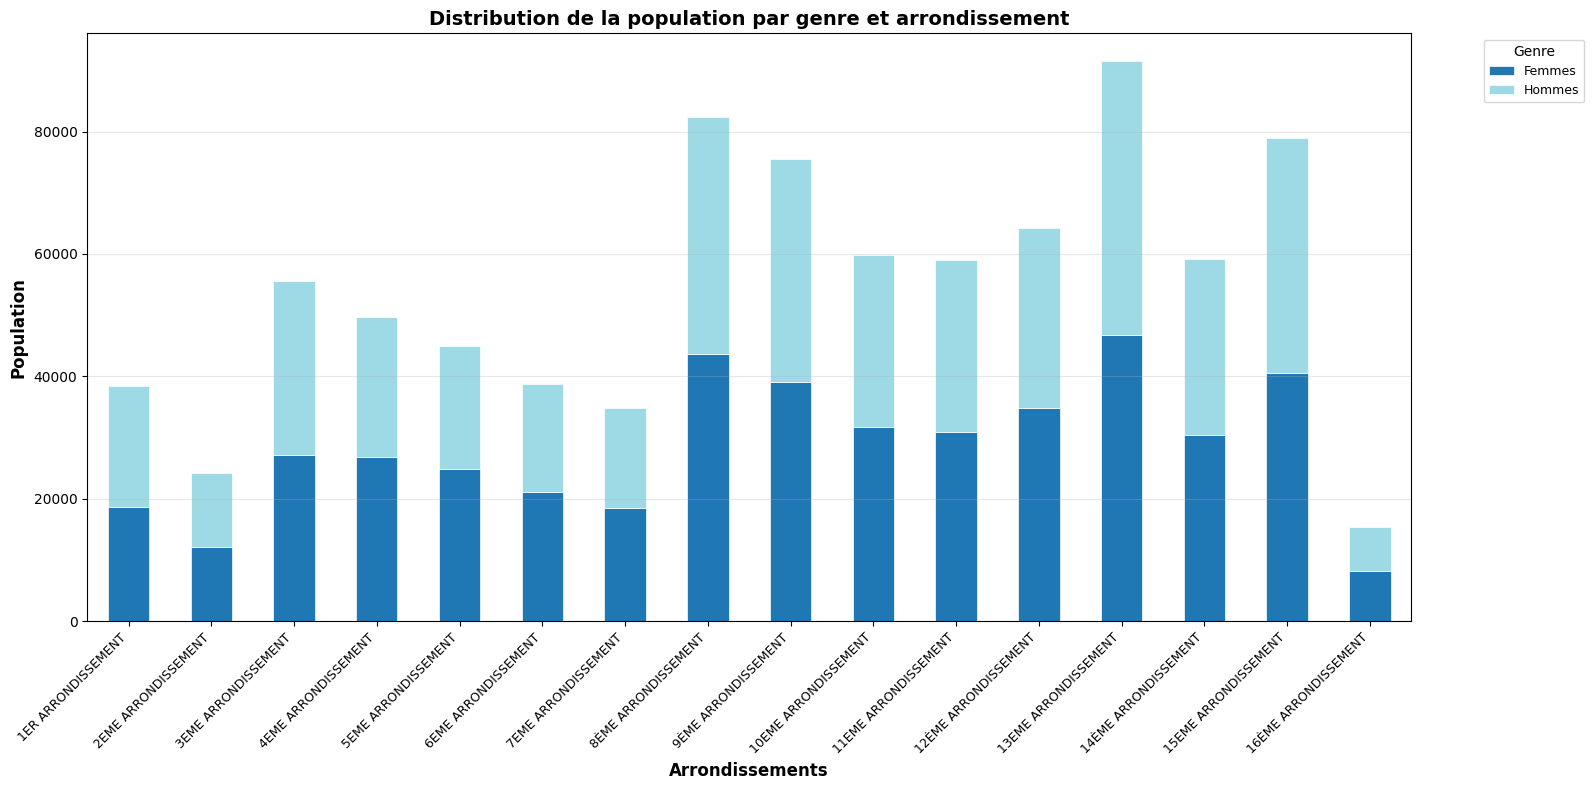


Population totale par arrondissement:
1ER ARRONDISSEMENT: 38,481 habitants
2EME ARRONDISSEMENT: 24,152 habitants
3EME ARRONDISSEMENT: 55,653 habitants
4EME ARRONDISSEMENT: 49,743 habitants
5EME ARRONDISSEMENT: 45,019 habitants
6EME ARRONDISSEMENT: 38,804 habitants
7EME ARRONDISSEMENT: 34,865 habitants
8ÈME ARRONDISSEMENT: 82,376 habitants
9ÈME ARRONDISSEMENT: 75,446 habitants
10EME ARRONDISSEMENT: 59,852 habitants
11EME ARRONDISSEMENT: 59,033 habitants
12ÈME ARRONDISSEMENT: 64,277 habitants
13EME ARRONDISSEMENT: 91,477 habitants
14ÈME ARRONDISSEMENT: 59,219 habitants
15EME ARRONDISSEMENT: 78,998 habitants
16ÈME ARRONDISSEMENT: 15,414 habitants


In [7]:
# Préparer les données pour le graphique empilé
pivot_data = df_genre.pivot_table(
    values='population_count',
    index='arrondissements',
    columns='Genre',
    aggfunc='sum',
    fill_value=0
)

# Trier par numéro d'arrondissement (du 1er au 16ème)
def extract_arr_number(arr_name):
    """Extraire le numéro d'arrondissement pour trier"""
    match = re.search(r'(\d+)', str(arr_name))
    return int(match.group(1)) if match else 999

pivot_data['_sort_key'] = pivot_data.index.map(extract_arr_number)
pivot_data = pivot_data.sort_values('_sort_key')
pivot_data = pivot_data.drop('_sort_key', axis=1)

# Créer le graphique empilé
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
pivot_data.plot(kind='bar', stacked=True, ax=ax, colormap='tab20', edgecolor='white', linewidth=0.5)

ax.set_xlabel('Arrondissements', fontsize=12, fontweight='bold')
ax.set_ylabel('Population', fontsize=12, fontweight='bold')
ax.set_title('Distribution de la population par genre et arrondissement', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Afficher aussi les totaux
totals = pivot_data.sum(axis=1)
print(f"\nPopulation totale par arrondissement:")
for arr, pop in totals.items():
    print(f"{arr}: {pop:,.0f} habitants")

In [8]:
# Test d'indépendance âge × arrondissement et âge × secteur (population)

# 1. Âge × Arrondissement
print("\n=== Test d'indépendance ÂGE × ARRONDISSEMENT (population) ===")
age_arr = pd.pivot_table(
    df_age,
    index="Tranche d'âge",
    columns="arrondissements",
    values="population_count",
    aggfunc='sum',
    fill_value=0
)

if age_arr.shape[0] > 1 and age_arr.shape[1] > 1:
    chi2, p, dof, expected = chi2_contingency(age_arr)
    print(f"Chi² = {chi2:.2f}, p-value = {p:.4f}, ddl = {dof}")
    if p < 0.05:
        print("Dépendance significative entre âge et arrondissement")
    else:
        print("Indépendance (pas de lien significatif)")
else:
    print("Pas assez de modalités pour le test")

# 2. Âge × Secteur
print("\n=== Test d'indépendance ÂGE × SECTEUR (population) ===")
age_sect = pd.pivot_table(
    df_age,
    index="Tranche d'âge",
    columns="secteur",
    values="population_count",
    aggfunc='sum',
    fill_value=0
)
if age_sect.shape[0] > 1 and age_sect.shape[1] > 1:
    chi2, p, dof, expected = chi2_contingency(age_sect)
    print(f"Chi² = {chi2:.2f}, p-value = {p:.4f}, ddl = {dof}")
    if p < 0.05:
        print("Dépendance significative entre âge et secteur")
    else:
        print("Indépendance (pas de lien significatif)")
else:
    print("Pas assez de modalités pour le test")

# 3. Genre × Arrondissement
print("\n=== Test d'indépendance GENRE × ARRONDISSEMENT (population) ===")
genre_arr = pd.pivot_table(
    df_genre,
    index="Genre",
    columns="arrondissements",
    values="population_count",
    aggfunc='sum',
    fill_value=0
)
if genre_arr.shape[0] > 1 and genre_arr.shape[1] > 1:
    chi2, p, dof, expected = chi2_contingency(genre_arr)
    print(f"Chi² = {chi2:.2f}, p-value = {p:.4f}, ddl = {dof}")
    if p < 0.05:
        print("Dépendance significative entre genre et arrondissement")
    else:
        print("Indépendance (pas de lien significatif)")
else:
    print("Pas assez de modalités pour le test")

# 4. Genre × Secteur
print("\n=== Test d'indépendance GENRE × SECTEUR (population) ===")
genre_sect = pd.pivot_table(
    df_genre,
    index="Genre",
    columns="secteur",
    values="population_count",
    aggfunc='sum',
    fill_value=0
)
if genre_sect.shape[0] > 1 and genre_sect.shape[1] > 1:
    chi2, p, dof, expected = chi2_contingency(genre_sect)
    print(f"Chi² = {chi2:.2f}, p-value = {p:.4f}, ddl = {dof}")
    if p < 0.05:
        print("Dépendance significative entre genre et secteur")
    else:
        print("Indépendance (pas de lien significatif)")
else:
    print("Pas assez de modalités pour le test")


=== Test d'indépendance ÂGE × ARRONDISSEMENT (population) ===
Chi² = 27843.18, p-value = 0.0000, ddl = 135
Dépendance significative entre âge et arrondissement

=== Test d'indépendance ÂGE × SECTEUR (population) ===
Chi² = 15666.87, p-value = 0.0000, ddl = 63
Dépendance significative entre âge et secteur

=== Test d'indépendance GENRE × ARRONDISSEMENT (population) ===
Chi² = 1063.79, p-value = 0.0000, ddl = 15
Dépendance significative entre genre et arrondissement

=== Test d'indépendance GENRE × SECTEUR (population) ===
Chi² = 785.46, p-value = 0.0000, ddl = 7
Dépendance significative entre genre et secteur


In [ ]:
# Charger les réponses du sondage
responses = pd.read_csv('../data/raw/responses-CoxcbW93-01KGADZKXK32XJ4Z1QMKK5DH1W-VVI741VFG01HMU7VUFGO2OLM.csv')

# Fonction de normalisation des noms
def normalize_name(s):
    if pd.isna(s):
        return s
    return s.strip().upper().replace("'", " ").replace("-", " ")

print(f"Sondage chargé: {len(responses)} réponses")

Sondage chargé: 2702 réponses


In [27]:
responses = responses[responses["Response Type"] == "completed"][["Dans quel quartier de Marseille habitez-vous ?", 
                                                                                "Quel est votre âge ?", "Quel est votre genre ?", "Submit Date (UTC)",
                                                                                "Response Type","Start Date (UTC)","Submit Date (UTC)"]]

In [28]:
responses.reset_index( drop=True, inplace=True )

In [ ]:
responses = responses[responses["Response Type"] == "completed"][["Dans quel quartier de Marseille habitez-vous ?", 
                                                                                "Quel est votre âge ?", "Quel est votre genre ?", "Submit Date (UTC)",
                                                                                "Response Type","Start Date (UTC)","Submit Date (UTC)"]]

# Extraction quartier, arrondissement, secteur depuis la colonne quartier du DataFrame responses
import re

def extract_arrondissement_from_quartier(q):
    if pd.isna(q):
        return None
    match = re.match(r"^(\d+|1ER)e?", str(q).strip(), re.IGNORECASE)
    if match:
        num_str = match.group(1)
        if num_str in ["1", "1ER", "1er", "1Er", "1e", "1E"]:
            return "1ER ARRONDISSEMENT"
        else:
            return f"{num_str}EME ARRONDISSEMENT"
    return None

def extract_quartier_name(q):
    if pd.isna(q):
        return None
    # Enlève le préfixe "1ER – ", "1er – ", "1e – ", "7e – ", etc. et met en majuscules
    return re.sub(r"^(\d+|1ER|1er|1e|1E)\s*e?\s*[-–—]\s*", "", str(q), flags=re.IGNORECASE).strip().upper()

def extract_secteur_from_arrondissement(arr):
    if pd.isna(arr):
        return None
    match = re.match(r"(\d+)", str(arr))
    if match:
        arr_num = int(match.group(1))
        for secteur, arrs in secteur_arr_mapping.items():
            if arr_num in arrs:
                return secteur
    return None

responses['arrondissement'] = responses["Dans quel quartier de Marseille habitez-vous ?"].apply(extract_arrondissement_from_quartier)
responses['quartier'] = responses["Dans quel quartier de Marseille habitez-vous ?"].apply(extract_quartier_name)
responses['secteur'] = responses['arrondissement'].apply(extract_secteur_from_arrondissement)

print(responses[['quartier', 'arrondissement', 'secteur']].head())

          quartier       arrondissement      secteur
0              NaN                  NaN          NaN
1  LE ROUCAS BLANC  7EME ARRONDISSEMENT  1ER SECTEUR
2    SAINT-CHARLES   1ER ARRONDISSEMENT  1ER SECTEUR
3              NaN                  NaN          NaN
4     SAINT-VICTOR  7EME ARRONDISSEMENT  1ER SECTEUR


In [40]:
responses.notna().sum() / responses.shape[0]

Dans quel quartier de Marseille habitez-vous ?    0.709125
Quel est votre âge ?                              0.981464
Quel est votre genre ?                            0.737643
Submit Date (UTC)                                 1.000000
Response Type                                     1.000000
Start Date (UTC)                                  1.000000
arrondissement                                    0.709125
quartier                                          0.709125
secteur                                           0.709125
dtype: float64

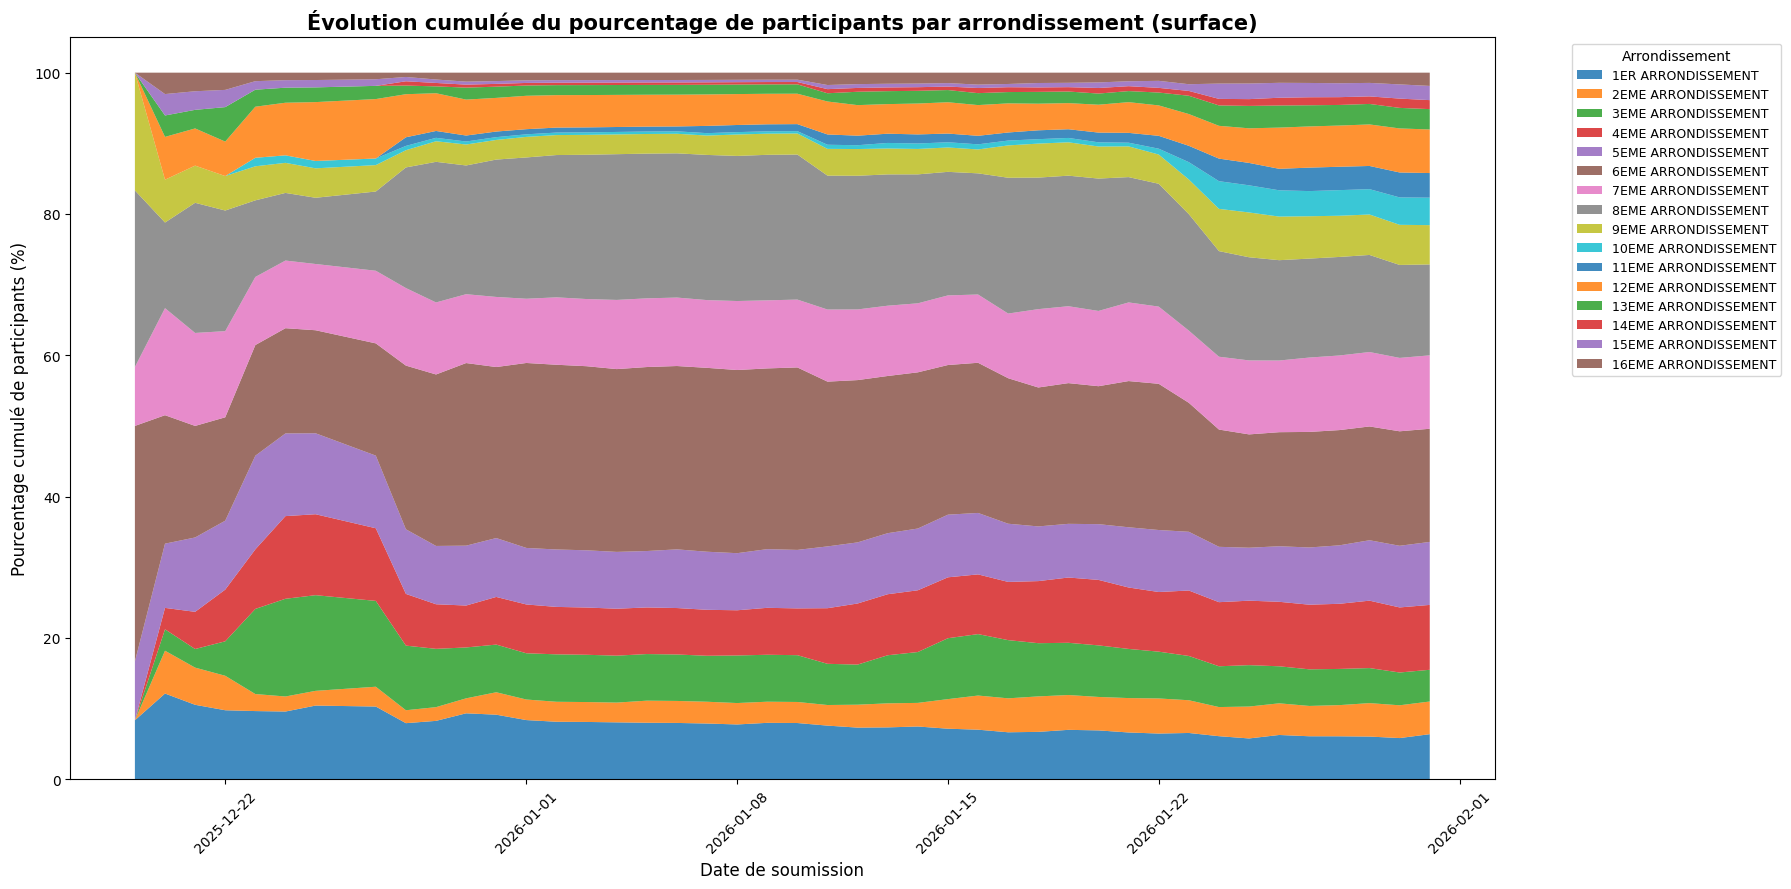

In [41]:
# Time series : évolution cumulée du pourcentage de participants par arrondissement (Submit Date en abscisse) - mode surface (stackplot)
import matplotlib.dates as mdates

# Vérifier les colonnes dupliquées
responses = responses.loc[:, ~responses.columns.duplicated()]

# S'assurer que la colonne date est bien au format datetime
responses['Submit Date (UTC)'] = pd.to_datetime(responses['Submit Date (UTC)'], errors='coerce')

# Grouper par date et arrondissement
participants_ts = responses.groupby([
    pd.Grouper(key='Submit Date (UTC)', freq='D'),
    'arrondissement'
]).size().reset_index(name='n_participants')

# Pivot pour avoir une colonne par arrondissement
pivot_ts = participants_ts.pivot(index='Submit Date (UTC)', columns='arrondissement', values='n_participants').fillna(0)

def arrondissement_sort_key(arr):
    match = re.match(r"(\d+)", str(arr))
    return int(match.group(1)) if match else 999
pivot_ts = pivot_ts.reindex(sorted(pivot_ts.columns, key=arrondissement_sort_key), axis=1)

# Calcul du cumul
pivot_ts_cum = pivot_ts.cumsum()

# Calcul du pourcentage cumulé par date (chaque ligne = 100%)
pivot_ts_pct = pivot_ts_cum.div(pivot_ts_cum.sum(axis=1), axis=0).fillna(0) * 100

# Tracer la série temporelle cumulée en pourcentage (stackplot)
fig, ax = plt.subplots(figsize=(18, 9))
ax.stackplot(pivot_ts_pct.index, pivot_ts_pct.values.T, labels=pivot_ts_pct.columns, alpha=0.85)

ax.set_xlabel('Date de soumission', fontsize=12)
ax.set_ylabel('Pourcentage cumulé de participants (%)', fontsize=12)
ax.set_title("Évolution cumulée du pourcentage de participants par arrondissement (surface)", fontsize=15, fontweight='bold')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
ax.legend(title='Arrondissement', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

In [42]:
responses_analysed = responses.copy()

In [43]:
responses_analysed = responses_analysed[responses_analysed["Dans quel quartier de Marseille habitez-vous ?"].notna()]

In [45]:
responses_analysed["Quel est votre âge ?"].unique()

<StringArray>
[       '35 à 44 ans',        '55 à 64 ans',        '65 à 75 ans',
        '45 à 54 ans',     'Plus de 75 ans',        '25 à 34 ans',
                  nan,        '18 à 24 ans', 'Ne se prononce pas',
        '11 à 14 ans',        '15 à 18 ans']
Length: 11, dtype: str

--- Répartition par ARRONDISSEMENT (% du total, accents harmonisés) ---


,Population Marseille (%),Répondants (%)
1ER ARRONDISSEMENT,4.365290,6.367292
2EME ARRONDISSEMENT,2.739366,4.624665
3EME ARRONDISSEMENT,6.312905,4.490617
4EME ARRONDISSEMENT,5.642412,9.182306
5EME ARRONDISSEMENT,5.106676,8.914209
6EME ARRONDISSEMENT,4.398638,16.018767
7EME ARRONDISSEMENT,3.953080,10.388740
8EME ARRONDISSEMENT,9.489208,12.868633
9EME ARRONDISSEMENT,8.760638,5.563003
10EME ARRONDISSEMENT,6.788976,3.887399



--- Répartition par SECTEUR (% du total, accents harmonisés) ---


,Population Marseille (%),Répondants (%)
secteur,,
1ER SECTEUR,8.318370,16.756032
2EME SECTEUR,9.052270,9.115282
3EME SECTEUR,10.749089,18.096515
4EME SECTEUR,13.887846,28.887399
5EME SECTEUR,15.549614,9.450402
6EME SECTEUR,14.151233,9.651475
7EME SECTEUR,17.251424,4.155496
8EME SECTEUR,11.040154,3.887399


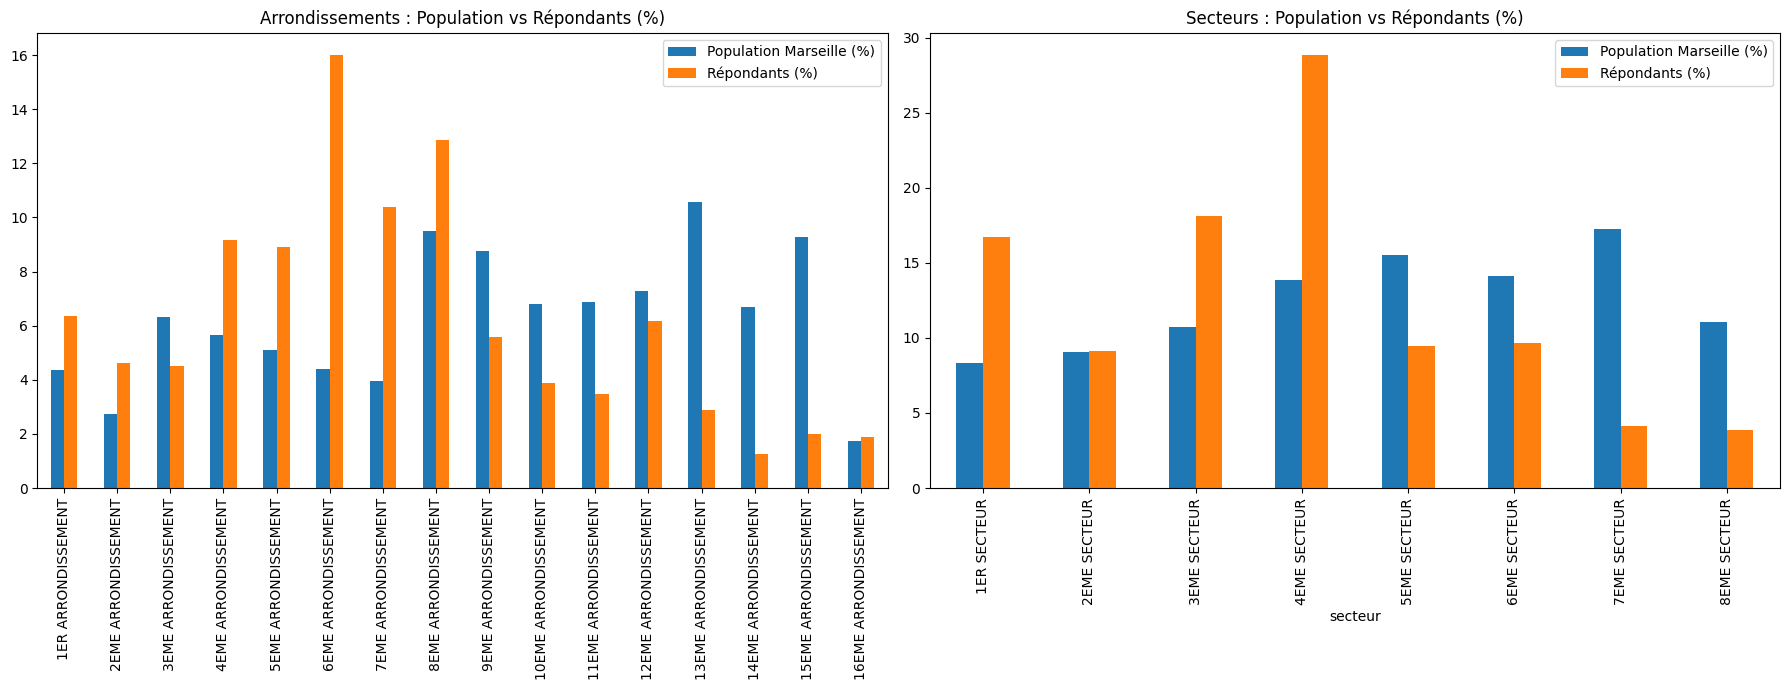

In [49]:
# Test de représentativité : comparaison de la répartition des répondants vs population Marseille
# (par arrondissement et par secteur) avec harmonisation des accents
import unicodedata

def strip_accents(s):
    if pd.isna(s):
        return s
    return ''.join(c for c in unicodedata.normalize('NFD', str(s)) if unicodedata.category(c) != 'Mn')

# Harmoniser les valeurs d'arrondissement et secteur dans les deux jeux de données
pop_arr = df_age.copy()
pop_arr['arrondissements'] = pop_arr['arrondissements'].apply(strip_accents).str.upper().str.strip()
pop_arr = pop_arr.groupby('arrondissements')['population_count'].sum().sort_index()
pop_arr_pct = pop_arr / pop_arr.sum() * 100

resp_arr = responses_analysed.copy()
resp_arr['arrondissement'] = resp_arr['arrondissement'].apply(strip_accents).str.upper().str.strip()
resp_arr = resp_arr['arrondissement'].value_counts().sort_index()
resp_arr_pct = resp_arr / resp_arr.sum() * 100

# Aligner les index pour comparaison
import re
arr_index = sorted(set(pop_arr.index) | set(resp_arr.index), key=lambda x: int(re.match(r'(\d+)', str(x)).group(1)) if re.match(r'(\d+)', str(x)) else 999)
pop_arr_pct = pop_arr_pct.reindex(arr_index, fill_value=0)
resp_arr_pct = resp_arr_pct.reindex(arr_index, fill_value=0)

print('--- Répartition par ARRONDISSEMENT (% du total, accents harmonisés) ---')
df_arr_compare = pd.DataFrame({'Population Marseille (%)': pop_arr_pct, 'Répondants (%)': resp_arr_pct})
display(df_arr_compare)

# Pour les secteurs
pop_sect = df_age.copy()
pop_sect['secteur'] = pop_sect['secteur'].apply(strip_accents).str.upper().str.strip()
pop_sect = pop_sect.groupby('secteur')['population_count'].sum().sort_index()
pop_sect_pct = pop_sect / pop_sect.sum() * 100

resp_sect = responses_analysed.copy()
resp_sect['secteur'] = resp_sect['secteur'].apply(strip_accents).str.upper().str.strip()
resp_sect = resp_sect['secteur'].value_counts().sort_index()
resp_sect_pct = resp_sect / resp_sect.sum() * 100

sect_index = sorted(set(pop_sect.index) | set(resp_sect.index))
pop_sect_pct = pop_sect_pct.reindex(sect_index, fill_value=0)
resp_sect_pct = resp_sect_pct.reindex(sect_index, fill_value=0)

print('\n--- Répartition par SECTEUR (% du total, accents harmonisés) ---')
df_sect_compare = pd.DataFrame({'Population Marseille (%)': pop_sect_pct, 'Répondants (%)': resp_sect_pct})
display(df_sect_compare)

# Visualisation
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
df_arr_compare.plot.bar(ax=axes[0], title="Arrondissements : Population vs Répondants (%)")
df_sect_compare.plot.bar(ax=axes[1], title="Secteurs : Population vs Répondants (%)")
plt.tight_layout()
plt.show()

In [50]:
# Test du Chi2 d'ajustement pour la représentativité par arrondissement et secteur
# + calcul des intervalles de représentativité (bornes basses/hautes)
from scipy.stats import chi2, chisquare
import numpy as np

# Fonction pour calculer l'intervalle de représentativité (intervalle de fluctuation)
def representativity_interval(p, n, alpha=0.05):
    # p: proportion théorique (population)
    # n: taille de l'échantillon
    # alpha: niveau de confiance (par défaut 95%)
    z = abs(np.percentile(np.random.normal(size=100000), 100*(1-alpha/2)))  # ~1.96 pour 95%
    # Mais on prend la valeur exacte :
    from scipy.stats import norm
    z = norm.ppf(1-alpha/2)
    se = np.sqrt(p * (1-p) / n)
    return np.clip(p - z*se, 0, 1), np.clip(p + z*se, 0, 1)

# 1. Par arrondissement
n_sample = resp_arr.sum()
obs = resp_arr.values
exp = pop_arr_pct.values / 100 * n_sample
chi2_stat, pval = chisquare(f_obs=obs, f_exp=exp)
print(f"\nTest du Chi2 d'ajustement (arrondissements) :\nChi2 = {chi2_stat:.2f}, p-value = {pval:.4f}")

# Calcul des intervalles de représentativité
arr_bornes = []
for p_theo in pop_arr_pct.values/100:
    borne_basse, borne_haute = representativity_interval(p_theo, n_sample)
    arr_bornes.append((borne_basse*100, borne_haute*100))

arr_bornes = np.array(arr_bornes)
df_arr_compare['Borne basse (%)'] = arr_bornes[:,0]
df_arr_compare['Borne haute (%)'] = arr_bornes[:,1]

print("\nTableau de représentativité par arrondissement :")
display(df_arr_compare)

# 2. Par secteur
n_sample_sect = resp_sect.sum()
obs_sect = resp_sect.values
exp_sect = pop_sect_pct.values / 100 * n_sample_sect
chi2_stat_sect, pval_sect = chisquare(f_obs=obs_sect, f_exp=exp_sect)
print(f"\nTest du Chi2 d'ajustement (secteurs) :\nChi2 = {chi2_stat_sect:.2f}, p-value = {pval_sect:.4f}")

sect_bornes = []
for p_theo in pop_sect_pct.values/100:
    borne_basse, borne_haute = representativity_interval(p_theo, n_sample_sect)
    sect_bornes.append((borne_basse*100, borne_haute*100))
sect_bornes = np.array(sect_bornes)
df_sect_compare['Borne basse (%)'] = sect_bornes[:,0]
df_sect_compare['Borne haute (%)'] = sect_bornes[:,1]

print("\nTableau de représentativité par secteur :")
display(df_sect_compare)


Test du Chi2 d'ajustement (arrondissements) :
Chi2 = 393.07, p-value = 0.0000

Tableau de représentativité par arrondissement :


,Population Marseille (%),Répondants (%),Borne basse (%),Borne haute (%)
1ER ARRONDISSEMENT,4.365290,6.367292,3.328530,5.402049
2EME ARRONDISSEMENT,2.739366,4.624665,1.911124,3.567607
3EME ARRONDISSEMENT,6.312905,4.490617,5.078896,7.546913
4EME ARRONDISSEMENT,5.642412,9.182306,4.471608,6.813217
5EME ARRONDISSEMENT,5.106676,8.914209,3.989683,6.223670
6EME ARRONDISSEMENT,4.398638,16.018767,3.358108,5.439169
7EME ARRONDISSEMENT,3.953080,10.388740,2.964361,4.941800
8EME ARRONDISSEMENT,9.489208,12.868633,8.002146,10.976269
9EME ARRONDISSEMENT,8.760638,5.563003,7.326065,10.195212
10EME ARRONDISSEMENT,6.788976,3.887399,5.512539,8.065413



Test du Chi2 d'ajustement (secteurs) :
Chi2 = 718.85, p-value = 0.0000

Tableau de représentativité par secteur :


,Population Marseille (%),Répondants (%),Borne basse (%),Borne haute (%)
secteur,,,,
1ER SECTEUR,8.318370,16.756032,6.917093,9.719647
2EME SECTEUR,9.052270,9.115282,7.596347,10.508193
3EME SECTEUR,10.749089,18.096515,9.177439,12.320739
4EME SECTEUR,13.887846,28.887399,12.133104,15.642588
5EME SECTEUR,15.549614,9.450402,13.710857,17.388371
6EME SECTEUR,14.151233,9.651475,12.382641,15.919826
7EME SECTEUR,17.251424,4.155496,15.334272,19.168575
8EME SECTEUR,11.040154,3.887399,9.449966,12.630341


In [51]:
# Calcul des poids de pondération par arrondissement (pour pondérer les réponses)
# Poids = (proportion population) / (proportion répondants)
# Si un arrondissement n'a aucun répondant, le poids sera NaN (à traiter selon le contexte)
poids_arr = pop_arr_pct / resp_arr_pct

df_arr_compare['Poids de pondération'] = poids_arr

print("\nTableau de pondération par arrondissement (à appliquer sur chaque réponse selon son arrondissement) :")
display(df_arr_compare[['Population Marseille (%)', 'Répondants (%)', 'Poids de pondération', 'Borne basse (%)', 'Borne haute (%)']])


Tableau de pondération par arrondissement (à appliquer sur chaque réponse selon son arrondissement) :


,Population Marseille (%),Répondants (%),Poids de pondération,Borne basse (%),Borne haute (%)
1ER ARRONDISSEMENT,4.365290,6.367292,0.685580,3.328530,5.402049
2EME ARRONDISSEMENT,2.739366,4.624665,0.592338,1.911124,3.567607
3EME ARRONDISSEMENT,6.312905,4.490617,1.405799,5.078896,7.546913
4EME ARRONDISSEMENT,5.642412,9.182306,0.614488,4.471608,6.813217
5EME ARRONDISSEMENT,5.106676,8.914209,0.572869,3.989683,6.223670
6EME ARRONDISSEMENT,4.398638,16.018767,0.274593,3.358108,5.439169
7EME ARRONDISSEMENT,3.953080,10.388740,0.380516,2.964361,4.941800
8EME ARRONDISSEMENT,9.489208,12.868633,0.737391,8.002146,10.976269
9EME ARRONDISSEMENT,8.760638,5.563003,1.574804,7.326065,10.195212
10EME ARRONDISSEMENT,6.788976,3.887399,1.746406,5.512539,8.065413
